# Pipeline with Stubs Checks Notebook

## paths + imports

In [1]:
import os, sys
from pathlib import Path

# Ensure repo root is on sys.path (so "import scripts..." works)
REPO_ROOT = Path.cwd().parent  
if (REPO_ROOT / "scripts").exists() is False and (REPO_ROOT.parent / "scripts").exists():
    REPO_ROOT = REPO_ROOT.parent

sys.path.insert(0, str(REPO_ROOT))

print("Repo root:", REPO_ROOT)
print("Scripts dir exists:", (REPO_ROOT / "scripts").exists())

import numpy as np
import matplotlib.pyplot as plt
import torch

Repo root: d:\Post Grad\NN & DL\An-Instance-Aware-Multi-Task-Network-for-Food-Calorie-Estimation-from-a-Single-Image\food_vision_playground
Scripts dir exists: True


## load one test image

Image: (225, 225, 3) uint8


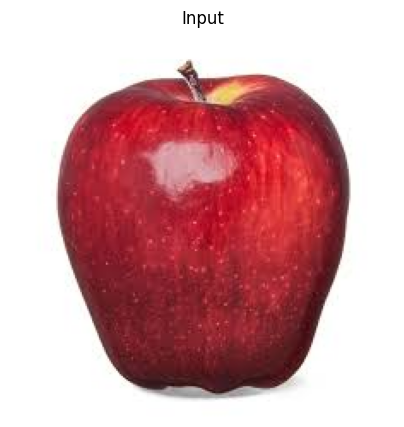

In [2]:
from scripts.utils import load_rgb, ensure_uint8_rgb

# Change this to any image you want
IMG_PATH = str(REPO_ROOT / "data" / "sample.jpg")

img = ensure_uint8_rgb(load_rgb(IMG_PATH))
H, W = img.shape[:2]
print("Image:", img.shape, img.dtype)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Input")
plt.axis("off")
plt.show()

## device check

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cpu


## load EfficientNet backbone

In [4]:
from scripts.efficientnet import load_efficientnet, run_efficientnet, describe_features

backbone, backbone_xform = load_efficientnet(
    model_name="tf_efficientnetv2_s",
    device=device,
    mode="backbone",
    out_indices=(1, 2, 3, 4),
)

print("Backbone loaded.")

c:\Users\ZBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Backbone loaded.


## load Mask R-CNN (TorchVision)

In [5]:
from scripts.maskrcnn_torchvision import load_maskrcnn

seg_model, seg_preprocess = load_maskrcnn(device=device)
print("Segmentation model loaded.")

Segmentation model loaded.


## load ZoeDepth + define depth_fn

In [6]:
from scripts.zoedepth import load_zoedepth, predict_depth

depth_model = load_zoedepth(device=device)
print("Depth model loaded.")

def depth_fn(depth_model, img_rgb_uint8, device="cuda"):
    # returns np.ndarray [H,W] float32
    return predict_depth(depth_model, img_rgb_uint8, device=device).depth

img_size [384, 512]


Using cache found in C:\Users\ZBook/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\ZBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal


c:\Users\ZBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Depth model loaded.


## dimension checks

In [7]:
from PIL import Image

img_pil = Image.fromarray(img)
x_back = backbone_xform(img_pil).unsqueeze(0).to(device)

feats = backbone(x_back)

print("type(feats):", type(feats))
if isinstance(feats, (list, tuple)):
    print("len(feats):", len(feats))
    for i, f in enumerate(feats):
        print(i, type(f), getattr(f, "shape", None))
else:
    print("shape(feats):", getattr(feats, "shape", None))

type(feats): <class 'list'>
len(feats): 4
0 <class 'torch.Tensor'> torch.Size([1, 48, 75, 75])
1 <class 'torch.Tensor'> torch.Size([1, 64, 38, 38])
2 <class 'torch.Tensor'> torch.Size([1, 160, 19, 19])
3 <class 'torch.Tensor'> torch.Size([1, 256, 10, 10])


## run the full pipeline

In [8]:
from scripts.pipeline import run_pipeline
from scripts.fusion_stub import FusionStub

out = run_pipeline(
    img_rgb_uint8=img,
    backbone_model=backbone,
    backbone_transform=backbone_xform,
    seg_model=seg_model,
    seg_preprocess=seg_preprocess,
    depth_model=depth_model,
    depth_fn=depth_fn,
    device=device,
    seg_score_thresh=0.5,
    fusion=FusionStub(),
)

print("✅ run_pipeline completed")
print("Instances:", len(out.instance_outputs))
print("Depth:", out.depth_map.shape, out.depth_map.dtype)
print("Backbone feature maps:", len(out.backbone_features))


✅ run_pipeline completed
Instances: 2
Depth: (225, 225) float32
Backbone feature maps: 4


## pipeline invariants / sanity asserts

In [9]:
assert out.depth_map.shape == (H, W), f"Depth shape {out.depth_map.shape} != {(H,W)}"
assert isinstance(out.instance_outputs, list), "instance_outputs must be a list"
assert len(out.backbone_features) > 0, "No backbone features returned"

for k, inst in enumerate(out.instance_outputs):
    assert inst.mask.shape == (H, W), f"inst[{k}] mask shape {inst.mask.shape} != {(H,W)}"
    assert inst.embedding.ndim == 1, f"inst[{k}] embedding must be 1D"
    assert inst.area_px == int(inst.mask.sum()), f"inst[{k}] area_px mismatch"

print("✅ Pipeline invariants passed")

if out.instance_outputs:
    print("Example embedding dim:", int(out.instance_outputs[0].embedding.shape[0]))
    print("Depth range:", float(np.nanmin(out.depth_map)), float(np.nanmax(out.depth_map)))


✅ Pipeline invariants passed
Example embedding dim: 530
Depth range: 1.4597660303115845 1.9902162551879883


## visualize depth + masks overlay

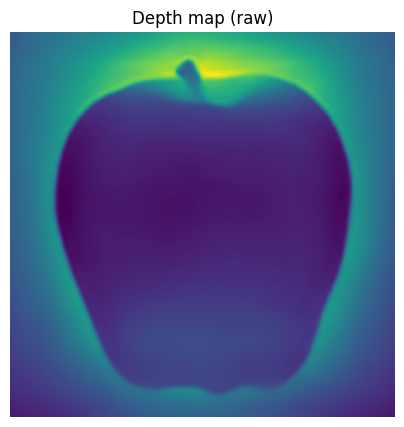

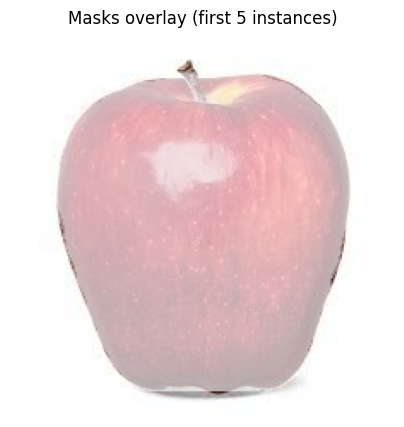

In [10]:
# Depth map
plt.figure(figsize=(5,5))
plt.imshow(out.depth_map)
plt.title("Depth map (raw)")
plt.axis("off")
plt.show()

# Masks overlay (up to 5)
overlay = img.copy().astype(np.float32)
for inst in out.instance_outputs[:5]:
    m = inst.mask
    overlay[m] = 0.6 * overlay[m] + 0.4 * 255  # simple bright overlay

plt.figure(figsize=(5,5))
plt.imshow(overlay.astype(np.uint8))
plt.title("Masks overlay (first 5 instances)")
plt.axis("off")
plt.show()


## optional: physics stub on top of pipeline output

In [11]:
from scripts.physics_stub import PhysicsCalorieEstimator

physics = PhysicsCalorieEstimator(default_density=1.0)

for i, inst in enumerate(out.instance_outputs[:10]):
    cal_proxy = physics.estimate(inst.area_px, inst.depth_median, inst.class_id)
    print(
        i,
        "score", f"{inst.score:.3f}",
        "area_px", inst.area_px,
        "d_med", f"{inst.depth_median:.4f}",
        "d_mean", f"{inst.depth_mean:.4f}",
        "cal_proxy", f"{cal_proxy:.2f}",
        "emb_dim", int(inst.embedding.shape[0]),
    )


0 score 0.864 area_px 26422 d_med 1.5197 d_mean 1.5372 cal_proxy 40152.20 emb_dim 530
1 score 0.804 area_px 26535 d_med 1.5194 d_mean 1.5355 cal_proxy 40318.59 emb_dim 530
